> 은행과 같은 금융기관의 리테일 금융소비자(개인 고객)에 대하여 가계신용대출(Home Credit Loan)을 할 경우 **고객이 대출금을 상환할지 Target 변수 분류 및 대출금액 예측** 프로젝트

### 신용대출상환 여부 TARGET 분류를 위한 베이스라인 모델 구축

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import missingno as msno
from typing import *
  # [데이터프레임 핸들링, 선형대수, 결측값 처리 목적 라이브러리 모듈]

from google.colab import drive
drive.mount("/content/drive")
  # [코랩에 구글 드라이브 마운트]

from sklearn.preprocessing import *
  # [연속형 변수 스케일링 및 범주형 변수 인코딩 목적 모든 라이브러리 모듈]
from sklearn.model_selection import train_test_split
  # [훈련용 및 검증용 데이터 셋 분할 목적 라이브러리 모듈]
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
  # [K-폴드 교차검증(랜덤 또는 타겟하는 클래스 변수 비율 층화) 및 그리드 서치 목적 라이브러리 모듈]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
  # [데이터 시각화 모듈]

from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
import sklearn.svm as svm
  # [분류 모델 모듈]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
  # [성능 평가 지표 모듈]

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
  # [클래스 불균형 모듈]

from sklearn.decomposition import PCA
  # [클래스 불균형 확인 시각화 모듈]

from sklearn.metrics import fbeta_score, make_scorer
  # [f-beta score 모듈]

Mounted at /content/drive


In [ ]:
NCB_MICE_FS_OD = pd.read_csv("/content/drive/MyDrive/NCB_MICE_FS.csv", index_col = False)
NCB_MICE_FS_OD.shape
  # [New Credit Bureau _ Impute NA with MICE _ Feature Selection with PCA, Filtering _ Outlier Detection with Isolation Forest]

(313519, 129)

In [ ]:
NCB_MICE_FS_OD.iloc[:, 6:124] = NCB_MICE_FS_OD.iloc[:, 6:124].astype("uint8")

In [ ]:
# TARGET 변수 카테고리화 하기

NCB_MICE_FS_OD["TARGET"] = NCB_MICE_FS_OD["TARGET"].astype("category")

In [ ]:
NCB_MICE_FS_OD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313519 entries, 0 to 313518
Columns: 129 entries, DAYS_EMPLOYED to duplicate
dtypes: category(1), float64(7), int64(4), uint8(117)
memory usage: 61.6 MB


In [ ]:
# dt_eval()
# 혼동행렬, 정확도, 민감도, 재현율, f1스코어를 한번에 출력하는 함수

def dt_eval(y_test, pred = None) :
  confusion = confusion_matrix(y_test, pred, labels = [1,0])
      # [1(양성)이 먼저 오는 혼동행렬 그리기]
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  print("혼동 행렬")
  print(confusion)

  print(f"정확도: {accuracy}")
  print(f"정밀도: {precision}")
  print(f"재현율: {recall}")
  print(f"F1: {f1}")
  print(f"F-0.75: {((1+0.75**2) * precision * recall) / ((0.75**2)*precision + recall)}")
  # print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

#### 1) 결정 트리 분류 모델
- 디폴트 상태에서 성능 평가를 통한 클래스 불균형, 과대 적합 확인
- split_ratio에 따른 성능 평가 지표 확인
- 지니 불순도, 엔트로피 불순도에 따른 변화 확인


In [ ]:
NCB_data = NCB_MICE_FS_OD.drop(["TARGET", "SK_ID_CURR", "SK_ID_PREV", "DAYS_BIRTH"], axis=1)
NCB_TARGET = NCB_MICE_FS_OD["TARGET"]
NCB_data.head()

# NCB_MICE_FS_OD.columns.get_loc("TARGET")
    # ["TARGET" 칼럼의 위치 : 123]

,DAYS_EMPLOYED,AMT_ANNUITY_y,AMT_ANNUITY_x,AMT_APPLICATION,AMT_GOODS_PRICE_x,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_CONTRACT_STATUS_Approved,...,NAME_GOODS_CATEGORY_Photo / Cinema Equipment,NAME_GOODS_CATEGORY_Sport and Leisure,NAME_GOODS_CATEGORY_Tourism,NAME_GOODS_CATEGORY_Vehicles,NAME_GOODS_CATEGORY_Weapon,NAME_GOODS_CATEGORY_XNA,AMT_CREDIT_x,AMT_CREDIT_y,duplicate,GENERATION
0,637,9251.775,24700.5,179055.0,351000.0,1,0,0,1,1,...,0,0,0,1,0,0,406597.5,179055.0,0,26
1,1188,64567.665,35698.5,337500.0,1129500.0,0,1,1,0,1,...,0,0,0,0,0,0,1293502.5,348637.5,0,46
2,1588,17885.835,27517.5,162598.5,454500.0,1,0,0,1,1,...,0,0,0,0,0,0,490495.5,162598.5,0,46
3,3130,8996.760,41301.0,98239.5,1395000.0,0,1,1,0,1,...,0,0,0,0,0,0,1560726.0,98239.5,0,38
4,449,27463.410,42075.0,247212.0,1530000.0,1,0,1,0,1,...,0,0,0,0,0,0,1530000.0,260811.0,0,52


In [ ]:
np.random.seed(2040)

In [ ]:
# train_test_split : [0.5, 0.4, 0.3, 0.2, 0.1]에 따른 성능 지표 확인
# split 확인

split = []
split = [1,2,3,4,5]

i = 0
i = []

for i in split :
  globals()["X_train_{}".format(i)], globals()["X_test_{}".format(i)], globals()["y_train_{}".format(i)], globals()["y_test_{}".format(i)] = train_test_split(NCB_data, NCB_TARGET,
                                                                                                                                                              test_size = i/10,
                                                                                                                                                              stratify = NCB_TARGET,
                                                                                                                                                              random_state = 2022)
  print( globals()["X_train_{}".format(i)].shape, globals()["X_test_{}".format(i)].shape)

(282167, 126) (31352, 126)
(250815, 126) (62704, 126)
(219463, 126) (94056, 126)
(188111, 126) (125408, 126)
(156759, 126) (156760, 126)


In [ ]:
# (1) 지니 불순도 사용

dt = DecisionTreeClassifier()
  # [모든 파라미터 default]

In [ ]:
# train_test_split : [0.5, 0.4, 0.3, 0.2, 0.1]에 따른 성능 지표 확인

g = 0
g = []

for g in split :
  globals()["dt_{}".format(g)] = dt.fit(globals()["X_train_{}".format(g)], globals()["y_train_{}".format(g)])
  globals()["evaluations_{}".format(g)] = dt_eval(globals()["y_test_{}".format(g)], globals()["dt_{}".format(g)].predict(globals()["X_test_{}".format(g)]))
  print(f"split: {g/10}")
  print(globals()["evaluations_{}".format(g)])

    # [정확도는 높으나 정밀도와 재현율이 상대적으로 매우 낮음을 확인, 클래스 불균형 예상]

혼동 행렬
[[ 1088  1486]
 [ 1719 27059]]
정확도: 0.8977736667517224
정밀도: 0.3876024225151407
재현율: 0.4226884226884227
F1: 0.40438580189555845
split: 0.1
None
혼동 행렬
[[ 2048  3099]
 [ 3475 54082]]
정확도: 0.8951582036233733
정밀도: 0.3708129639688575
재현율: 0.3979016903050321
F1: 0.38388003748828486
split: 0.2
None
혼동 행렬
[[ 2795  4926]
 [ 5715 80620]]
정확도: 0.8868652717529982
정밀도: 0.3284371327849589
재현율: 0.3619997409661961
F1: 0.34440268621773146
split: 0.3
None
혼동 행렬
[[  3416   6878]
 [  7856 107258]]
정확도: 0.8825114825210513
정밀도: 0.3030518097941803
재현율: 0.33184379250048573
F1: 0.31679495502179356
split: 0.4
None
혼동 행렬
[[  3916   8952]
 [ 10113 133779]]
정확도: 0.8783809645317683
정밀도: 0.2791360752726495
재현율: 0.3043207957724588
F1: 0.2911848905082351
split: 0.5
None


In [ ]:
# (2) 엔트로피 사용

dt_entropy = DecisionTreeClassifier(criterion = "entropy")
  # [불순도를 엔트로피로 설정하고 나머지 파라미터는 디폴트로 설정]

In [ ]:
# train_test_split : [0.5, 0.4, 0.3, 0.2, 0.1]에 따른 성능 지표 확인

f = 0
f = []

for f in split :
  globals()["dt_ent_{}".format(f)] = dt_entropy.fit(globals()["X_train_{}".format(f)], globals()["y_train_{}".format(f)])
  globals()["evaluation_ent_{}".format(f)] = dt_eval(globals()["y_test_{}".format(f)], globals()["dt_ent_{}".format(f)].predict(globals()["X_test_{}".format(f)]))
  print(f"split: {f/10}")
  print(globals()["evaluation_ent_{}".format(f)])

    # [엔트로피를 사용한 모델도 정확도는 높지만 정밀도와 재현율이 상대적으로 매우 낮은 것을 보아 클래스 불균형을 확인할 수 있음]
    # [정확도만 봤을 때, 지니 불순도와 엔트로피 사이에 확연한 차이는 없음, 따라서 속도가 상대적으로 빠른 지니 불순도 이용]

혼동 행렬
[[ 1127  1447]
 [ 1575 27203]]
정확도: 0.903610614952794
정밀도: 0.4170984455958549
재현율: 0.43783993783993785
F1: 0.4272175890826384
split: 0.1
None
혼동 행렬
[[ 1989  3158]
 [ 3327 54230]]
정확도: 0.8965775708088798
정밀도: 0.3741534988713318
재현율: 0.3864387021565961
F1: 0.38019688425881676
split: 0.2
None
혼동 행렬
[[ 2875  4846]
 [ 5123 81212]]
정확도: 0.8940099515182445
정밀도: 0.35946486621655416
재현율: 0.37236109312265253
F1: 0.3657993511037598
split: 0.3
None
혼동 행렬
[[  3601   6693]
 [  7260 107854]]
정확도: 0.8887391553967849
정밀도: 0.33155326397200996
재현율: 0.3498154264620167
F1: 0.34043961238477904
split: 0.4
None
혼동 행렬
[[  4034   8834]
 [  9583 134309]]
정확도: 0.8825146721102322
정밀도: 0.29624733788646546
재현율: 0.3134908299658066
F1: 0.3046252595808948
split: 0.5
None


과대적합 확인하기

```
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
confusion_matrix(y_test, dt.pred(X_test))
		# 1 [y_test, X_test 에 대한 모델링 성능 평가]
confusion_matirx(y_trian, dt.pred(X_train))
		# 2 [y_train, X_train에 대한 모델링 성능 평가]
```

[시각화] https://nicola-ml.tistory.com/93

In [ ]:
# 과대적합 확인 (y_train, X_train에 대한 모델링 성능 평가) ??

g = 0
g = []

for g in split :
  globals()["dt_{}".format(g)] = dt.fit(globals()["X_train_{}".format(g)], globals()["y_train_{}".format(g)])
  globals()["evaluations_train_{}".format(g)] = dt_eval(globals()["y_train_{}".format(g)], globals()["dt_{}".format(g)].predict(globals()["X_train_{}".format(g)]))
  print(f"split: {g/10}")
  print(globals()["evaluations_train_{}".format(g)])

    # [모든 경우에서 정확도, 정밀도, 재현율, F1-score 가 1이 나옴 : 트리가 데이터를 정확히 학습한 꼴]
    # [아마도 파이썬은 중간에 노드를 제한하는 기능이 없어서 끝까지 내려가기 때문에 이런 현상이 발생했다고 예상]

혼동 행렬
[[ 23162      0]
 [     0 259005]]
정확도: 1.0
정밀도: 1.0
재현율: 1.0
F1: 1.0
split: 0.1
None
혼동 행렬
[[ 20589      0]
 [     0 230226]]
정확도: 1.0
정밀도: 1.0
재현율: 1.0
F1: 1.0
split: 0.2
None
혼동 행렬
[[ 18015      0]
 [     0 201448]]
정확도: 1.0
정밀도: 1.0
재현율: 1.0
F1: 1.0
split: 0.3
None
혼동 행렬
[[ 15442      0]
 [     0 172669]]
정확도: 1.0
정밀도: 1.0
재현율: 1.0
F1: 1.0
split: 0.4
None
혼동 행렬
[[ 12868      0]
 [     0 143891]]
정확도: 1.0
정밀도: 1.0
재현율: 1.0
F1: 1.0
split: 0.5
None


#### 2) 클래스 불균형 조정
* ADASYN, SMOTE
* 가중치 설정 : 아래 정의한 함수 내에서 가중치 설정과 하이퍼파라미터 조정을 동시에 진행함.
  > DecisionTreeClassWeight( ) : 최적의 가중치 탐색
  >
  > MaxDepth(  ), MaxDepth_2(  ) : 최적의 max_depth 탐색
  >
  > DecisionTreeCostComplexity(  ) : 최적의 ccp_alpha 탐색
  >
  > DT ( ) : 하이퍼파라미터 설정 후 모델의 성능 평가 지표
  >
  > DecisionTreeCustom( ) : 최종 모델 성능 평가 및 feature importance 추출

In [ ]:
X = NCB_MICE_FS_OD.drop(["TARGET", "SK_ID_CURR", "SK_ID_PREV", "DAYS_BIRTH"], axis = 1)
y = NCB_MICE_FS_OD["TARGET"]

'''
# [DecisionTreeClassWeight()에 있던 코드]
# [표준화 할지 결정하기]

X = NCB_MICE_FS_OD.drop(["TARGET", "SK_ID_CURR", "SK_ID_PREV"], axis = 1)
scaler = StandardScaler()
  # [표준화가 모델 성능에 미치는 영향은 없음]
X_num_list = X.select_dtypes(include = ["integer", "float"]).columns.tolist()
X.loc[:, X_num_list] = scaler.fit_transform(X.loc[:, X_num_list])
y = NCB_MICE_FS_OD["TARGET"]
'''

'\n# [DecisionTreeClassWeight()에 있던 코드]\n# [표준화 할지 결정하기]\n\nX = NCB_MICE_FS_OD.drop(["TARGET", "SK_ID_CURR", "SK_ID_PREV"], axis = 1)\nscaler = StandardScaler()\n  # [표준화가 모델 성능에 미치는 영향은 없음]\nX_num_list = X.select_dtypes(include = ["integer", "float"]).columns.tolist()\nX.loc[:, X_num_list] = scaler.fit_transform(X.loc[:, X_num_list])\ny = NCB_MICE_FS_OD["TARGET"]\n'

##### "세대" 변수 만들기
* DAYS_BIRTH / 365

In [ ]:
# 세대 변수 만들기
NCB_MICE_FS_OD["GENERATION"] = round(NCB_MICE_FS_OD["DAYS_BIRTH"]/365, 0)

```
for index in range(len(NCB_MICE_FS_OD.index)) :
  if NCB_MICE_FS_OD.loc[index, "GENERATION"] < 20:
    NCB_MICE_FS_OD.loc[index, "GENERATION"] = 10
  elif NCB_MICE_FS_OD.loc[index, "GENERATION"] < 30:
    NCB_MICE_FS_OD.loc[index, "GENERATION"] = 20
  elif NCB_MICE_FS_OD.loc[index, "GENERATION"] < 40:
    NCB_MICE_FS_OD.loc[index, "GENERATION"] = 30
  elif NCB_MICE_FS_OD.loc[index, "GENERATION"] < 50:
    NCB_MICE_FS_OD.loc[index, "GENERATION"] = 40
  elif NCB_MICE_FS_OD.loc[index, "GENERATION"] < 60:
    NCB_MICE_FS_OD.loc[index, "GENERATION"] = 50
  else:
    NCB_MICE_FS_OD.loc[index, "GENERATION"] = 60

  # [세대(나이대) 범주형 변수 생성]
```

In [ ]:
def DAYS_BIRTH_category(age):
  age = (age // 10) * 10
    # [24 나누기 10의 몫인 2에 10을 곱하여 20대로 정의]
  return age

In [ ]:
NCB_MICE_FS_OD["GENERATION"] = NCB_MICE_FS_OD["GENERATION"].apply(DAYS_BIRTH_category)

In [ ]:
NCB_MICE_FS_OD["GENERATION"] = NCB_MICE_FS_OD["GENERATION"].astype("category")

In [ ]:
NCB_MICE_FS_OD = pd.get_dummies(NCB_MICE_FS_OD, columns = ["GENERATION"])

In [ ]:
NCB_MICE_FS_OD.head()

,DAYS_EMPLOYED,AMT_ANNUITY_y,DAYS_BIRTH,AMT_ANNUITY_x,AMT_APPLICATION,AMT_GOODS_PRICE_x,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,...,AMT_CREDIT_x,AMT_CREDIT_y,SK_ID_CURR,SK_ID_PREV,duplicate,GENERATION_20.0,GENERATION_30.0,GENERATION_40.0,GENERATION_50.0,GENERATION_60.0
0,637,9251.775,9461,24700.5,179055.0,351000.0,1,0,0,1,...,406597.5,179055.0,100002,1038818.0,0,1,0,0,0,0
1,1188,64567.665,16765,35698.5,337500.0,1129500.0,0,1,1,0,...,1293502.5,348637.5,100003,2636178.0,0,0,0,1,0,0
2,1588,17885.835,16941,27517.5,162598.5,454500.0,1,0,0,1,...,490495.5,162598.5,100008,2218188.0,0,0,0,1,0,0
3,3130,8996.760,13778,41301.0,98239.5,1395000.0,0,1,1,0,...,1560726.0,98239.5,100009,1413109.0,0,0,1,0,0,0
4,449,27463.410,18850,42075.0,247212.0,1530000.0,1,0,1,0,...,1530000.0,260811.0,100010,2349489.0,0,0,0,0,1,0


In [ ]:
# [Trial&Error]클래스 불균형 해소를 위한 오버샘플링 - ADASYN : 과대적합
# ADASYN, SMOTE는 '가짜 샘플'을 생성하여 클래스 불균형을 해소하기 때문에 TARGET을 예측할 때 '진짜 샘플'이 지워질 우려가 있어 선택하지 않음.

'''
ada = ADASYN()
NCB_data_res, NCB_TARGET_res = ada.fit_resample(NCB_data, NCB_TARGET)
    # [NCB_TARGET] 0 : 287783, 1 : 25736
    # [NCB_TARGET_res] 0 : 287783, 1 : 283738

# 원본 데이터와 ADASYN 후 데이터 클래스 분포 시각화
# [Error] 시각화 실패
```
pca = PCA(n_components=2)
data_vis = pca.fit_transform(NCB_data)
data_res_vis = pca.fit_transform(NCB_data_res)

f, (ax1, ax2) = plt.subplots(1,2)
c0 = ax1.scatter(data_vis[NCB_TARGET == 0,0], data_vis[NCB_TARGET == 0,1], label = "Class #0",
                 alpha=0.5)
c1 = ax1.scatter(data_vis[NCB_TARGET == 1,0], data_vis[NCB_TARGET == 1,1], label = "Class #1",
            alpha = 0.5)
ax1.set_title("Original set")


ax2.scatter(data_res_vis[NCB_TARGET_res == 0,0], data_res_vis[NCB_TARGET_res == 0,1],
            label="Class #0", alpha = 0.5)
ax2.scatter(data_res_vis[NCB_TARGET_res == 1,0], data_res_vis[NCB_TARGET_res == 1,1],
            label="Class #1", alpha = 0.5)
ax2.set_title("ADASYN set")

for ax in (ax1, ax2):
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.get_xaxis().tick_bottom()
  ax.get_yaxis().tick_left()
  ax.spines['left'].set_position(('outward',10))
  ax.spines['bottom'].set_position(('outward', 10))
  ax.set_xlim([-6,8])
  ax.set_ylim([-6,6])

#plt.rcParams['figure.figsize'] = (15,10)
plt.figlegend((c0, c1), ("Class #0", "Class #1"), loc='lower center',
              ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()
```

# train_test_split (0.5~0.1)
i = 0
i = []

for i in split :
  globals()["X_train_{}".format(i)], globals()["X_test_{}".format(i)], globals()["y_train_{}".format(i)], globals()["y_test_{}".format(i)] = train_test_split(NCB_data_res, NCB_TARGET_res,
                                                                                                                                                              test_size = i/10)
  print( globals()["X_train_{}".format(i)].shape, globals()["X_test_{}".format(i)].shape)

# 성능평가
f = 0
f = []

for f in split :
  globals()["dt_{}".format(f)] = dt.fit(globals()["X_train_{}".format(f)], globals()["y_train_{}".format(f)])
  globals()["evaluations_{}".format(f)] = dt_eval(globals()["y_test_{}".format(f)], globals()["dt_{}".format(f)].predict(globals()["X_test_{}".format(f)]))
  print(f"split: {f/10}")
  print(globals()["evaluations_{}".format(f)])
    # [정확도, 정밀도, 재현율 모두 90% 이상으로, 과대적합이 발생함]
'''

##### (1) 클래스 불균형 해소를 위한 클래스 가중치 설정

> DecisionTreeClassWeight()

In [ ]:
# DecisionTreeClassWeight()
# 의사결정 분류나무의 train:test 분할비율, 소수 클래스 가중치를 입력하여 모형을 적합하여
# F-Beta score(beta = 0.75), performance measure(금융회사의 기대손익)을 예측, 최적의 가중치 탐색하는 함수
# 출력값은 혼동행렬, 정밀도, 재현율, 오분류율, F-Beta 점수, performance_measure

def DecisionTreeClassWeight(split_ratio: float, tree_depth: int, lowclass_weight: float, alpha: float):

  # 훈련용 및 검증용 데이터 셋 분할
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      random_state = 2022,
                                                      test_size = split_ratio)
    # [훈련용 및 검증용 데이터 셋 분할비율 split_ratio로 입력값 설정]

  # 의사결정나무 최적의 가중치 탐색을 위한 모형 적합(model fitting)

  weights = {0:1, 1:lowclass_weight}
    # [클래스별 가중치 설정] 다수클래스 0 = 1, 소수클래스 1 = lowclass_weight로 입력값 설정
  decisionTreePruned = DecisionTreeClassifier(random_state = 2023,
                                              ccp_alpha = alpha,
                                              max_depth = tree_depth,
                                              class_weight = weights,
                                              criterion = "gini")
  decisionTreePruned.fit(X_train, y_train)
  y_pred = decisionTreePruned.predict(X_test)
  y_pred = np.array(y_pred)
  y_test = np.array(y_test)

  # 혼동행렬 작성 후 F-Beta 점수(모형 성능평가지표) 반환

  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1:
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0:
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1:
      FP += 1
    if y_test[i] == 0 and y_pred[i] == 0:
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)
  print(confusionMatrix)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  print("정밀도 :", Precision)
  print("재현율 :", Recall)
  print("오분류율 :", (FN + FP) / (TP + FN + FP + TN))
  print("F-Beta 점수 :", ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall))

  # 결정트리의 깊이 출력 -> 실패

  print("결정트리의 깊이 :", decisionTreePruned.get_depth())

  # 분류 가중치 테이블

  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]
  DBWeights

  # 분류 가중치 단위 조정 : 자연로그 변환

  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  classifyWeights = classifyWeights.transpose()

  # 금융회사의 기대손실(Loss)

  classifyWeights["CapitalExpectedP&L"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedP&L"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
  print(classifyWeights)
  print("캐피탈 오분류비용 :", sum(classifyWeights["CapitalExpectedP&L"]))
  print("손해보험 오분류비용 :", sum(classifyWeights["InsuranceExpectedP&L"]))

  # 의사결정트리 시각화 -> 에러
    # [TypeError: can only concatenate str (not "numpy.uint64") to str]
    # [AttributeError: 'Series' object has no attribute 'columns']# os.environ["PATH"] += os.pathsep + r"C:/Users/master14/graphviz-2.44.1-win32/Graphviz/bin"
  '''
  export_graphviz(decisionTreePruned,
                  out_file = "tree.dot",
                  class_names = ["0", "1"],
                    # decisionTreePruned.classes_
                  feature_names = X.columns.tolist(),
                    # decisionTreePruned.feature_names_in_
                  impurity = True,
                  filled = True)
  with open("tree.dot") as f:
    dot_graph = f.read()
  return graphviz.Source(dot_graph)
  '''

In [ ]:
# max_depth 그리드 서치, class_weight(가중치 신용위험에 대한 가중치 1/p, (p=연체확률값))

def MaxDepth(split_ratio: float):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      random_state = 2022,
                                                      test_size = split_ratio)
  default_wt = round(1/np.mean(y_train==1),0)
  target_wt = [default_wt if target == 1 else 1 for target in y_train]
    # [클래스별 가중치 설정] 신용위험에 대한 가중치 1/p, (p=연체확률값)
    # [fit() 함수의 파라미터인 [sample_weight]의 값으로 들어가야 함]

  DT = DecisionTreeClassifier(random_state = 2023, criterion = "gini")
  grid_param = {"max_depth" : list(range(17, 24, 1))}
  f_beta = make_scorer(fbeta_score, beta=0.75)
    # [beta = 0.75 : 가중치 8/10, 9/13 의 중간값]
  grid_search = GridSearchCV(DT, grid_param, cv=5, scoring = f_beta)
  grid_search.fit(X_train, y_train, sample_weight = target_wt)
  print(f"split_ratio: {split_ratio}")
  print(f"max_depth 최적 파라미터: {grid_search.best_params_}")
  print(f"최적 max_depth일 때의 F-beta값: {grid_search.best_score_}")

In [ ]:
MaxDepth(split_ratio = 0.2)

split_ratio: 0.2
max_depth 최적 파라미터: {'max_depth': 23}
최적 max_depth일 때의 F-beta값: 0.2327047251096534


In [ ]:
MaxDepth(split_ratio = 0.3)

split_ratio: 0.3
max_depth 최적 파라미터: {'max_depth': 23}
최적 max_depth일 때의 F-beta값: 0.22653693899471677


In [ ]:
MaxDepth(split_ratio = 0.4)

split_ratio: 0.4
max_depth 최적 파라미터: {'max_depth': 23}
최적 max_depth일 때의 F-beta값: 0.22424571482339925


In [ ]:
MaxDepth(split_ratio = 0.5)

split_ratio: 0.5
max_depth 최적 파라미터: {'max_depth': 23}
최적 max_depth일 때의 F-beta값: 0.20815155283144518


In [ ]:
# class_weight = {0:1, 1:3} 일 때의 최적 max_depth

def MaxDepth_2(split_ratio: float):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      random_state = 2022,
                                                      test_size = split_ratio)
  weights = {0:1, 1:3}
  grid_param = {"max_depth" : list(range(17, 24, 1))}
  DT_2 = DecisionTreeClassifier(random_state = 2022, criterion = "gini", class_weight = weights)
  f_beta = make_scorer(fbeta_score, beta=0.75)
  grid_search = GridSearchCV(DT_2, grid_param, cv=5, scoring = f_beta)
  grid_search.fit(X_train, y_train)
  print(f"split_ratio: {split_ratio}")
  print(f"max_depth 최적 파라미터: {grid_search.best_params_}")
  print(f"최적 max_depth일 때의 F-beta값: {grid_search.best_score_}")

In [ ]:
MaxDepth_2(split_ratio = 0.2)

split_ratio: 0.2
max_depth 최적 파라미터: {'max_depth': 23}
최적 max_depth일 때의 F-beta값: 0.301365079649599


In [ ]:
MaxDepth_2(split_ratio = 0.3)

split_ratio: 0.3
max_depth 최적 파라미터: {'max_depth': 23}
최적 max_depth일 때의 F-beta값: 0.2947449661544706


In [ ]:
MaxDepth_2(split_ratio = 0.4)

split_ratio: 0.4
max_depth 최적 파라미터: {'max_depth': 23}
최적 max_depth일 때의 F-beta값: 0.26482942409159493


In [ ]:
MaxDepth_2(split_ratio = 0.5)

split_ratio: 0.5
max_depth 최적 파라미터: {'max_depth': 23}
최적 max_depth일 때의 F-beta값: 0.24049667466228467


##### (2) 의사결정트리의 하이퍼파라미터를 튜닝하는 과정에서 발견한 몇가지 규칙성

* 다수 : 소수 클래스 가중치를 **1 : 12(1/소수 클래스 확률값)**로 주어 **5:5 균형인 상황**보다 **1 : 3**으로 주어 **4:1의 클래스 불균형이 완화된 상황**에서 performance measure인 F-0.75 점수가 유리함을 확인함
* Train 데이터를 train(80%) : validation(20%)으로 분할하여 5겹 교차검증을 수행한 결과보다 Train(train + validataion, 80%) : Test(20%)로 분할하여 수행한 결과가 더 유리함을 확인함
* 의사결정 트리 분류기의 GridSearchCV(격자탐색 교차검증)에서 최적화된 하이퍼파라미터 값(트리의 최대 깊이)로 그리드 내 가장 큰 수를 반환함

In [ ]:
# DT()
# 출력값은 소수클래스 가중치가 3, 다수클래스 가중치가 1이고 max_depth가 depth = 20 ~ 23일 때의 성능지표

def DT(split_ratio : float,
       depths: float,
       impurity: object):
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      random_state = 2022)
  weights = {0:1, 1:3}
  dt = DecisionTreeClassifier(max_depth = depths,
                              class_weight = weights,
                              random_state = 2022,
                              criterion = impurity)
  dt.fit(X_train, y_train)
  print(dt_eval(y_test, dt.predict(X_test)))
  print(dt_eval(y_train, dt.predict(X_train)))

In [ ]:
DT(split_ratio = 0.2, depths = 40, impurity = "gini")
  # [트리의 최대깊이가 30 ~ 40일 때 과적합되는 문제 발생]

혼동 행렬
[[ 2509  3925]
 [ 4367 67579]]
정확도: 0.8942077060474611
정밀도: 0.36489237929028506
재현율: 0.3899595896798259
F1: 0.3770097670924117
F-0.75: 0.37353652290944606
None
혼동 행렬
[[ 19179    123]
 [    84 215753]]
정확도: 0.9991196696422117
정밀도: 0.9956393085189222
재현율: 0.993627603357165
F1: 0.9946324387397899
F-0.75: 0.9949141569452571
None


In [ ]:
DT(split_ratio = 0.2, depths = 21, impurity = "gini")
DT(split_ratio = 0.2, depths = 21, impurity = "entropy")

혼동 행렬
[[ 2115  4319]
 [ 4041 67905]]
정확도: 0.8933401377902526
정밀도: 0.3435672514619883
재현율: 0.32872241218526577
F1: 0.3359809372517871
F-0.75: 0.33807112441017373
None
혼동 행렬
[[ 13839   5463]
 [  3752 212085]]
정확도: 0.9608104142656047
정밀도: 0.7867091126144051
재현율: 0.7169723344731116
F1: 0.7502236196568456
F-0.75: 0.7600939420968684
None
혼동 행렬
[[ 1855  4579]
 [ 3793 68153]]
정확도: 0.8931870375095687
정밀도: 0.3284348441926346
재현율: 0.28831209201119057
F1: 0.3070683661645423
F-0.75: 0.3127655556604665
None
혼동 행렬
[[ 11987   7315]
 [  5035 210802]]
정확도: 0.9474778747889546
정밀도: 0.7042063212313476
재현율: 0.6210237281110765
F1: 0.6600044048012332
F-0.75: 0.6718115990763782
None


> DeicisionTreeCostComplexity()
  * [ver1] max_depth =None, split_ratio = ??, lowclass_weight = ??
>  
> DecisionTreeCostComplexity_2()
  * [ver2] max_depth = ??, split_ratio, lowclass_weight =??

In [ ]:
# DeicisionTreeCostComplexity()
# 의사결정 분류나무의 xerror + alpha*xstd를 최소화하는 ccp_alpha를 찾는 함수
# 출력값은 비용 복잡도(가중계수 alpha)가 증가할 때 트리의 리트노드 불순도의 변화 그래프

def DecisionTreeCostComplexity(split_ratio: float,
                               lowclass_weight: float):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      random_state = 2022,
                                                      test_size = split_ratio)
    # [훈련용 및 검증용 데이터 셋 분할비율 split_ratio로 입력값 설정]
  weights = {0:1, 1:lowclass_weight}
    # [클래스별 가중치 설정] 다수클래스 0 = 1, 소수클래스 1 = lowclass_weight로 입력값 설정
  DecisionTree = DecisionTreeClassifier(random_state = 2023,
                                        class_weight = weights)
    # [정지규칙, 가지치기, 분리기준 모두 디폴트 설정]
    # [소수 클래스 TARGET 1 가중치 조정]
  path = DecisionTree.cost_complexity_pruning_path(X_train, y_train)
  ccp_alphas, impurities = path.ccp_alphas, path.impurities
    # [가지치기 과정에서 유효한 알파(가중계수)와 총 리프 노드의 불순도 반환]

  fig, ax = plt.subplots()
  ax.plot(ccp_alphas[:-1],
          impurities[:-1],
          marker = "o",
          drawstyle = "steps-post")
  ax.set_xlabel("Effective alpha")
  ax.set_ylabel("Total Impurity of leaf nodes")
  ax.set_title("Total Impurity vs effective alpha for training set")

  '''
  [실행시간 문제]

  clfs: List = []
    # [classifier 리스트]
  for ccp_alpha in ccp_alphas:
    # [정지규칙인 최적의 알파(가중계수)를 적용하여 결정 트리 학습]
    # [전체 트리를 가지치기하는 알파]
    clf = DecisionTreeClassifier(random_state = 2023,
                                 ccp_alpha = ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

  y_pred = clf.predict(X_test)
  confusionMatrix = confusion_matrix(y_test, y_pred)
  print(confusionMatrix)
    # [가지치기한 결정트리의 혼동행렬 출력]
    # TN FP
    # FN TP

  print(
      "Number of nodes in the last tree is {} with ccp_alpha: {}".format(
          clf[-1].tree_.node_count, ccp_alphas[-1]
          ))
  '''

In [ ]:
# DeicisionTreeCostComplexity_2()
# 의사결정 분류나무의 xerror + alpha*xstd를 최소화하는 ccp_alpha를 찾는 함수
# 출력값은 비용 복잡도(가중계수 alpha)가 증가할 때 트리의 리트노드 불순도의 변화 그래프

def DecisionTreeCostComplexity_2(split_ratio: float,
                                 lowclass_weight: float,
                                 depths: float):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      random_state = 2022,
                                                      test_size = split_ratio)
    # [훈련용 및 검증용 데이터 셋 분할비율 split_ratio로 입력값 설정]
  weights = {0:1, 1:lowclass_weight}
    # [클래스별 가중치 설정] 다수클래스 0 = 1, 소수클래스 1 = lowclass_weight로 입력값 설정
  DecisionTree = DecisionTreeClassifier(random_state = 2023,
                                        class_weight = weights,
                                        max_depth = depths)
    # [정지규칙, 가지치기, 분리기준 모두 디폴트 설정]
    # [소수 클래스 TARGET 1 가중치 조정]
  path = DecisionTree.cost_complexity_pruning_path(X_train, y_train)
  ccp_alphas, impurities = path.ccp_alphas, path.impurities
    # [가지치기 과정에서 유효한 알파(가중계수)와 총 리프 노드의 불순도 반환]

  fig, ax = plt.subplots()
  ax.plot(ccp_alphas[:-1],
          impurities[:-1],
          marker = "o",
          drawstyle = "steps-post")
  ax.set_xlabel("Effective alpha")
  ax.set_ylabel("Total Impurity of leaf nodes")
  ax.set_title("Total Impurity vs effective alpha for training set")

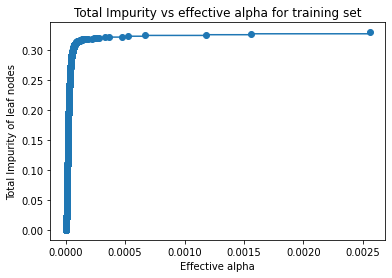

In [ ]:
# ccp_alpha 찾기

DecisionTreeCostComplexity(split_ratio = 0.2,
                           lowclass_weight = 3)

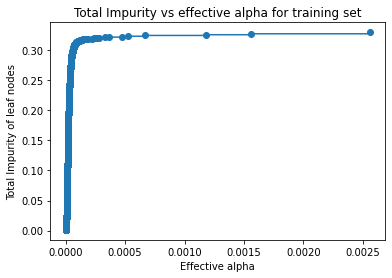

In [ ]:
DecisionTreeCostComplexity_2(split_ratio = 0.2,
                             lowclass_weight = 3,
                             depths = 40)

In [ ]:
# [Trials & Errors] 최적의 lowclass_weight 찾기

'''
# 최적의 lowclass_weight 찾기 1
# LowClassWeight()
# split_ratio를 넣었을 때, 최적의 lowclass_weight 파라미터를 찾기 위한 함수
# 출력값은 low_class_weight를 그리드 서치했을 때 나오는 best_params_
# [Warning] 클래스 불균형 해소를 보려면 정확도와 이외의 평가 지표를 비교해야할 거 같은데
# GridSearchCV에서 scoring = "f1"으로 한정했기 때문에 클래스 불균형이 해소된 것인지 확인하기엔 부적절한 거 같음.

def LowClassWeight(split_ratio: float):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      random_state = 2022,
                                                      test_size = split_ratio)
  # weights = {0:1, 1:lowclass_weight}
  DecisionTree = DecisionTreeClassifier(random_state = 2023)
  param_grid = {'class_weight' : [{0:1, 1:10}, {0:1, 1:20}, {0:1, 1:30}, {0:1, 1:40}, {0:1, 1:50},
                                  {0:1, 1:60}, {0:1, 1:70}, {0:1, 1:80}, {0:1, 1:90}]}
  #[10, 30, 30, 40, 50, 60, 70, 80, 90]
  # lowclass_weight = [10, 30, 30, 40, 50, 60, 70, 80, 90]
  grid_search = GridSearchCV(DecisionTree, param_grid, cv=5, scoring = "f1")
  grid_search.fit(X_train, y_train)
  print(grid_search.best_params_)

LowClassWeight(split_ratio = 0.5)
    # [{'class_weight': {0: 1, 1: 20}}] : split_ratio = 0.5 일 때는 lowclass_weight(가중치)가 20일 때 최적
    # [7분 7초]

'''

'''
# 최적의 lowclass_weight 찾기 2
# LowClassWeight_2()
# split_ratio를 넣었을 때, 최적의 lowclass_weight 파라미터를 찾기 위한 함수
# 출력값은 split_ratio에 대해 각 lowclass_weight가 지정되었을 때의 혼동행렬 및 평가 지표들

def LowClassWeight_2(split_ratio: float):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      random_state = 2022,
                                                      test_size = split_ratio)
  lowclass_weight = [10, 20, 30, 40, 50, 60, 70, 80, 90]
  for i in lowclass_weight :
    weights = {0:1, 1:i}
    DecisionTree = DecisionTreeClassifier(random_state = 2023,
                                          class_weight = weights)
    globals()["DecisionTree_{}".format(i)] = DecisionTree.fit(X_train, y_train)
    globals()["lc_evaluation_{}".format(i)] = dt_eval(y_test, globals()["DecisionTree_{}".format(i)].predict(X_test))
    print(f"lowclass_weight: {i}")
    print(globals()["lc_evaluation_{}".format(i)])

LowClassWeight_2(split_ratio = 0.5)
# LowClassWeight_2(split_ratio = 0.4)
# LowClassWeight_2(split_ratio = 0.3)
# LowClassWeight_2(split_ratio = 0.2)
# LowClassWeight_2(split_ratio = 0.1)

'''

'''
[클래스 불균형 시각화]
https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html
  # [Import Error : Boundary]
'''

##### (3) 최종 모델 (split_ratio = 0.2, max_detpth = 21, ccp_alpha = 0,  criterion = "gini")

> DecisionTreeCustom()

In [ ]:
# DecisionTreeCustom()
# 의사결정 분류나무의 train:test 분할비율, 비용복잡도/가중계수, 소수 클래스 가중치를 입력하여 모형을 적합하고 performance measure(금융회사의 기대손익)을 예측하는 함수
# 출력값은 혼동행렬, 정확도-정밀도-재현율, performance_measure, TARGET = 1이 될 분류 확률의 분포를 나타내는 바이올린 플롯
# 행렬곱을 numpy없이 구현하는 방법 : [[sum(x*Prediction) for x in i] for i in zip(*listcapital, *listinsurance)]


def DecisionTreeCustom(split_ratio: float, alpha: float, impurity: object):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      random_state = 2022,
                                                      test_size = split_ratio)
    # [훈련용 및 검증용 데이터 셋 분할비율 split_ratio로 입력값 설정]
  weights = {0:1, 1:3}
    # [클래스별 가중치 설정] 다수클래스 0 = 1, 소수클래스 1 = 3으로 입력값 설정
  decisionTreePruned = DecisionTreeClassifier(random_state = 2023,
                                              max_depth = 21,
                                              ccp_alpha = alpha,
                                              class_weight = weights,
                                              criterion = impurity)
  decisionTreePruned.fit(X_train, y_train)
  y_pred = decisionTreePruned.predict(X_test)
  y_pred = np.array(y_pred)
  y_test = np.array(y_test)

  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1:
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0:
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1:
      FP += 1
    if y_test[i] == 0 and y_pred[i] == 0:
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)
  print(confusionMatrix)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  print("정확도 :", (TP + TN) / (TP + FN + FP + TN))
  print("정밀도 :", Precision)
  print("재현율 :", Recall)
  print("F-Beta 점수 :", ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall))

  # Feature Importance
  dt_series = pd.Series(decisionTreePruned.feature_importances_, index = X.columns)
  dt_top_20 = dt_series.sort_values(ascending=False)[:20]
  plt.title('Feature Importance Top 20')
  sns.barplot(x=dt_top_20, y=dt_top_20.index)
  plt.show()

  # 분류 가중치 테이블
  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]
  DBWeights

  # 분류 가중치 단위 조정 : 자연로그 변환
  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  print(classifyWeights)

  classifyWeights = classifyWeights.transpose()
  print(classifyWeights)

  classifyWeights["CapitalExpectedP&L"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedP&L"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
  print(classifyWeights)

    # [금융회사의 기대손익(Profit & Loss)]
  print(sum(classifyWeights["CapitalExpectedP&L"]))
  print(sum(classifyWeights["InsuranceExpectedP&L"]))
    # logey = x, x^e = y (e = 2.718281828459045235360287471352)
    # log10y = x, x^10 = y
    # 1인당 분류 가중치를 산정하는 방식에 대한 고민이 필요함

    # DB손보는 최근 보유고객 1,000만 명을 돌파 (한국경제, 2022-06-30)
    # DB캐피탈은 DB손해보험의 종속기업(연결실체)이며
    # 자본금, 시가총액, 자산 규모 및 건전성, 월간 이용고객 수를 측정하는 KPI(MAU), ROE 등 면에서
    # 열세한바 해당 차이가 반영될 경우 예측된 1조 781억 원은 과대평가되었음을 확인 가능

  decisionTreeProb = decisionTreePruned.predict_proba(X_test)
  print(pd.DataFrame(decisionTreeProb).describe())
  # sns.violinplot(decisionTreeProb)
    # [분류 확률의 분포 출력]

In [ ]:
'''
DecisionTreeCustom(split_ratio=0.2, alpha=0.000068, impurity="gini")
  # [ccp_alpha 는 정확도를 높이는 전략이므로 정밀도, 재현율, f1 score 등의 지표는 되려 낮아질 수 있다.]
  # [ccp_alpha = 0]
'''

[[ 1772  3375]
 [ 3219 54338]]
정확도 : 0.894839244705282
정밀도 : 0.3550390703265879
재현율 : 0.344278220322518
F-Beta 점수 : 0.3510885329571482


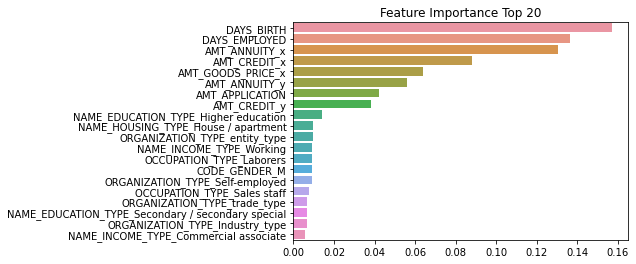

                FN      FP
Capital       -8.0   -10.0
Insurance     -9.0   -13.0
Prediction  3375.0  3219.0
    Capital  Insurance  Prediction
FN     -8.0       -9.0      3375.0
FP    -10.0      -13.0      3219.0
    Capital  Insurance  Prediction  CapitalExpectedP&L  InsuranceExpectedP&L
FN     -8.0       -9.0      3375.0            -27000.0              -30375.0
FP    -10.0      -13.0      3219.0            -32190.0              -41847.0
-59190.0
-72222.0
                  0             1
count  62704.000000  62704.000000
mean       0.872810      0.127190
std        0.241836      0.241836
min        0.000000      0.000000
25%        0.878735      0.000000
50%        0.979564      0.020436
75%        1.000000      0.121265
max        1.000000      1.000000


In [ ]:
DecisionTreeCustom(split_ratio = 0.2, alpha = 0, impurity = "gini")

In [ ]:
def DecisionTreePlot(split_ratio: float, alpha: float, impurity: object):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      random_state = 2022,
                                                      test_size = split_ratio)
    # [훈련용 및 검증용 데이터 셋 분할비율 split_ratio로 입력값 설정]
  weights = {0:1, 1:3}
    # [클래스별 가중치 설정] 다수클래스 0 = 1, 소수클래스 1 = 3으로 입력값 설정
  decisionTreePruned = DecisionTreeClassifier(random_state = 2023,
                                              max_depth = 30,
                                              ccp_alpha = alpha,
                                              class_weight = weights,
                                              criterion = impurity)
  decisionTreePruned.fit(X_train, y_train)
  y_pred = decisionTreePruned.predict(X_test)
  y_pred = np.array(y_pred)
  y_test = np.array(y_test)

  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1:
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0:
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1:
      FP += 1
    if y_test[i] == 0 and y_pred[i] == 0:
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)
  print(confusionMatrix)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  print("정확도 :", (TP + TN) / (TP + FN + FP + TN))
  print("정밀도 :", Precision)
  print("재현율 :", Recall)
  print("F-Beta 점수 :", ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall))

  # 분류 가중치 테이블
  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]
  DBWeights

  # 분류 가중치 단위 조정 : 자연로그 변환
  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  print(classifyWeights)

  classifyWeights = classifyWeights.transpose()
  print(classifyWeights)

  classifyWeights["CapitalExpectedP&L"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedP&L"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
  print(classifyWeights)

    # [금융회사의 기대손익(Profit & Loss)]
  print(sum(classifyWeights["CapitalExpectedP&L"]))
  print(sum(classifyWeights["InsuranceExpectedP&L"]))

  # decisionTreeProb = decisionTreePruned.predict_proba(X_test)
  # sns.violinplot(decisionTreeProb)
    # [분류 확률의 분포 출력]

  # 의사결정트리 시각화

  DV_names = np.array(["1", "0"])
  IV_names = X.columns.tolist()

  plt.figure(figsize = (30, 4))
  plot_tree(decisionTreePruned,
            class_names = DV_names,
            feature_names = IV_names,
            filled = True,
            max_depth = 3)
  plt.title("Tuning Decision Tree")
  plt.show()

  # dtNode = export_text(decisionTreePruned, feature_names = IV_names)
  # print(dtNode)

  '''
  DV_names = np.array(["1", "0"])
  IV_names = X.columns.tolist()

  export_graphviz(decisionTreePruned,
                  out_file = "tree.dot",
                  class_names = DV_names,
                    # decisionTreePruned.classes_
                  feature_names = IV_names,
                    # decisionTreePruned.feature_names_in_
                  impurity = True,
                  filled = True)

  with open("tree.dot") as f:
    dot_graph = f.read()
  return graphviz.Source(dot_graph)
  '''

  # 의사결정경계 시각화

  '''
  for pairindex, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    ax = plt.subplot(2, 3, pairindex + 1)
    plt.tight_layout(h_pad = 0.5, w_pad = 0.5, pad = 2.5)
    DecisionBoundaryDisplay
  '''

[[ 2010  3137]
 [ 3315 54242]]
정확도 : 0.8971038530237305
정밀도 : 0.37746478873239436
재현율 : 0.3905187487857004
F-Beta 점수 : 0.3820624529549965
                FN      FP
Capital       -8.0   -10.0
Insurance     -9.0   -13.0
Prediction  3137.0  3315.0
    Capital  Insurance  Prediction
FN     -8.0       -9.0      3137.0
FP    -10.0      -13.0      3315.0
    Capital  Insurance  Prediction  CapitalExpectedP&L  InsuranceExpectedP&L
FN     -8.0       -9.0      3137.0            -25096.0              -28233.0
FP    -10.0      -13.0      3315.0            -33150.0              -43095.0
-58246.0
-71328.0


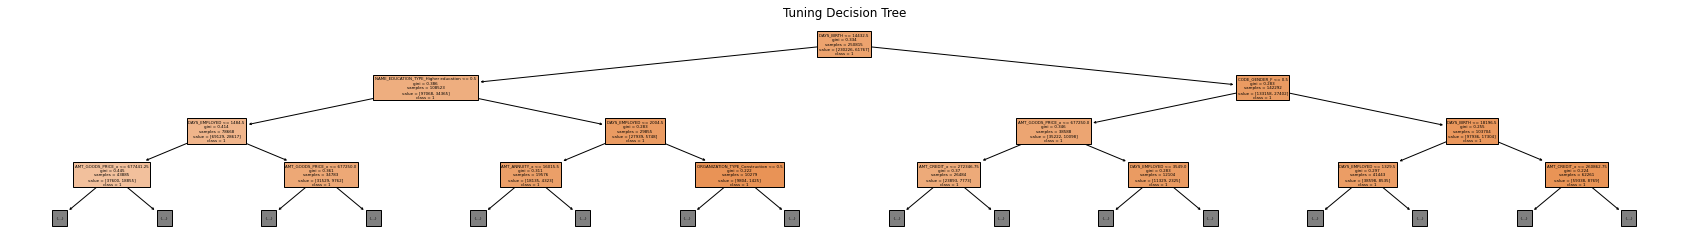

In [ ]:
DecisionTreePlot(split_ratio = 0.2, alpha = 0, impurity = "gini")

##### (4) 변수 중요도에 따른 21차원으로 축소 후 모델 적합

모든 performance measure가 악화하는 문제 발생하여 적절한 대안이 아님을 확인

In [ ]:
X_reduction_numeric = X.select_dtypes(exclude = ["uint8"])
X_numeric_list = X_reduction_numeric.columns.tolist()

In [ ]:
fourBinsDiscretizer = KBinsDiscretizer(n_bins = 5,
                                       encode = "ordinal",
                                       strategy = "quantile")
  # 연속형 변수를 4개 구간에 따라 범주형 변수로 변환

X_reduction_numeric = pd.DataFrame(
    fourBinsDiscretizer.fit_transform(X_reduction_numeric),
    columns = X_numeric_list)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [ ]:
X_reduction_dummy = X.loc[
    :, ["NAME_EDUCATION_TYPE_Higher education",
        "NAME_EDUCATION_TYPE_Secondary / secondary special",
        "NAME_HOUSING_TYPE_House / apartment",
        "ORGANIZATION_TYPE_entity_type",
        "ORGANIZATION_TYPE_Self-employed",
        "ORGANIZATION_TYPE_trade_type",
        "ORGANIZATION_TYPE_Industry_type",
        "NAME_INCOME_TYPE_Working",
        "NAME_INCOME_TYPE_Commercial associate",
        "OCCUPATION_TYPE_Laborers",
        "OCCUPATION_TYPE_Sales staff",
        "CODE_GENDER_M"]]

# X.iloc[:, 0:30].info()
# X.iloc[:, 31:60].info()
# X.iloc[:, 61:90].info()
# X.iloc[:, 91:117].info()

In [ ]:
X_reduction = pd.concat(
    [X_reduction_numeric, X_reduction_dummy], axis = 1
)

In [ ]:
X_reduction = X_reduction.astype("category")

In [ ]:
# DecisionTreeReduction() : 21차원으로 축소 후 의사결정 트리 분류기 적합

def DecisionTreeReduction(X: pd.DataFrame, y: pd.Series, split_ratio: float, alpha: float, depth: int, impurity: object):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      random_state = 2022,
                                                      test_size = split_ratio)
    # [훈련용 및 검증용 데이터 셋 분할비율 split_ratio로 입력값 설정]

  decisionTreePruned = DecisionTreeClassifier(random_state = 2023,
                                              max_depth = depth,
                                              ccp_alpha = alpha,
                                              criterion = impurity)
  decisionTreePruned.fit(X_train, y_train)
  y_pred = decisionTreePruned.predict(X_test)
  y_pred = np.array(y_pred)
  y_test = np.array(y_test)

  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1:
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0:
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1:
      FP += 1
    if y_test[i] == 0 and y_pred[i] == 0:
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)
  print(confusionMatrix)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  print("정확도 :", (TP + TN) / (TP + FN + FP + TN))
  print("정밀도 :", Precision)
  print("재현율 :", Recall)
  print("F-Beta 점수 :", ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall))

  # 특징 중요도
  dt_series = pd.Series(decisionTreePruned.feature_importances_, index = X.columns)
  dt_top_21 = dt_series.sort_values(ascending=False)[:21]
  plt.title("Feature Importance Top 21")
  sns.barplot(x = dt_top_21, y = dt_top_21.index)
  plt.show()

  # 분류 가중치 테이블
  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]
  DBWeights

  # 분류 가중치 단위 조정 : 자연로그 변환
  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  print(classifyWeights)

  classifyWeights = classifyWeights.transpose()
  print(classifyWeights)

  classifyWeights["CapitalExpectedLoss"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedLoss"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
  print(classifyWeights)

  print(sum(classifyWeights["CapitalExpectedLoss"]))
  print(sum(classifyWeights["InsuranceExpectedLoss"]))

  decisionTreeProb = decisionTreePruned.predict_proba(X_test)
  print(pd.DataFrame(decisionTreeProb).describe())
    # [분류 확률의 분포 출력]

[[ 1389  3758]
 [ 4797 52760]]
정확도 : 0.8635653227864251
정밀도 : 0.22453928225024247
재현율 : 0.2698659413250437
F-Beta 점수 : 0.2389899448722978


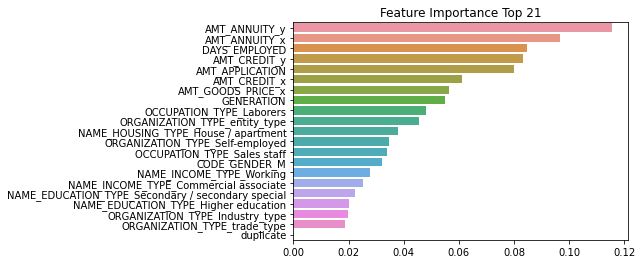

                FN      FP
Capital       -8.0   -10.0
Insurance     -9.0   -13.0
Prediction  3758.0  4797.0
    Capital  Insurance  Prediction
FN     -8.0       -9.0      3758.0
FP    -10.0      -13.0      4797.0
    Capital  Insurance  Prediction  CapitalExpectedLoss  InsuranceExpectedLoss
FN     -8.0       -9.0      3758.0             -30064.0               -33822.0
FP    -10.0      -13.0      4797.0             -47970.0               -62361.0
-78034.0
-96183.0
                  0             1
count  62704.000000  62704.000000
mean       0.861510      0.138490
std        0.251873      0.251873
min        0.000000      0.000000
25%        0.835784      0.000000
50%        1.000000      0.000000
75%        1.000000      0.164216
max        1.000000      1.000000


In [ ]:
DecisionTreeReduction(X = X_reduction,
                      y = y,
                      split_ratio = 0.2,
                      alpha = 0,
                      depth = 21,
                      impurity = "gini")

In [ ]:
X_dummy = X.select_dtypes(include = ["uint8"])

In [ ]:
X_binsDiscretize = pd.concat(
    [X_reduction_numeric, X_dummy], axis = 1)

In [ ]:
# DecisionTreeReduction(X = X_binsDiscretize, split_ratio = 0.2, alpha = 0, depth = 23, impurity = "gini")
  # [연속형 변수를 4분위수에 따라 5구간으로 분리하여 범주형 변수로 변환하는 방식은 성능을 악화시키는 대안]

##### (5) SMOTE : K-최근접 이웃 알고리즘 기반의 합성과잉표본추출 기법

In [ ]:
smote = SMOTE(random_state = 2022, k_neighbors = 5, sampling_strategy = "minority")
X_smote, y_smote = smote.fit_resample(X, y)
  # [합성표본추출기법 SMOTE 활용] 5:5 클래스 균형

In [ ]:
# sampling_strategy로 불균형 비율 설정하기
'''
smote_2 = SMOTE(random_state = 2022, k_neighbors = 5, sampling_strategy = {1:25736*6})
X_smote2, y_smote2 = smote_2.fit_resample(X, y)

print(X_smote2.shape, y_smote2.shape)
Counter(y_smote2)
  # [합성표본추출기법 SMOTE 활용] {1:4}, {1:3}, {1:2} 클래스 균형
  # [sampling_strategy = {1:77208}, Counter({1: 77208, 0: 287783})]
  # [sampling_strategy = {1:102944}, Counter({1: 102944, 0: 287783})]
  # [sampling_strategy = {1:154416}, Counter({1: 154416, 0: 287783})]
'''

'\nsmote_2 = SMOTE(random_state = 2022, k_neighbors = 5, sampling_strategy = {1:25736*6})\nX_smote2, y_smote2 = smote_2.fit_resample(X, y)\n\nprint(X_smote2.shape, y_smote2.shape)\nCounter(y_smote2)\n  # [합성표본추출기법 SMOTE 활용] {1:4}, {1:3}, {1:2} 클래스 균형\n  # [sampling_strategy = {1:77208}, Counter({1: 77208, 0: 287783})]\n  # [sampling_strategy = {1:102944}, Counter({1: 102944, 0: 287783})]\n  # [sampling_strategy = {1:154416}, Counter({1: 154416, 0: 287783})]\n'

In [ ]:
# SMOTE 후 max_depth GridSearch

DT_2 = DecisionTreeClassifier(random_state = 2023, criterion = "gini")
grid_param = {"max_depth" : list(range(17, 24, 1))}
f_beta = make_scorer(fbeta_score, beta=0.75)
  # [beta = 0.75 : 가중치 8/10, 9/13 의 중간값]
grid_search = GridSearchCV(DT_2, grid_param, cv=5, scoring = f_beta)
grid_search.fit(X_smote, y_smote)
print(f"max_depth 최적 파라미터: {grid_search.best_params_}")
print(f"최적 max_depth일 때의 F-beta값: {grid_search.best_score_}")

  # max_depth 최적 파라미터: {'max_depth': 18}
  # 최적 max_depth일 때의 F-beta값: 0.9195730667598262

max_depth 최적 파라미터: {'max_depth': 18}
최적 max_depth일 때의 F-beta값: 0.9195730667598262


[[51465  6092]
 [ 3135 54422]]
정확도 : 0.9198446757127717
정밀도 : 0.9425824175824176
재현율 : 0.8941570964435256
F-Beta 점수 : 0.9245566116441855


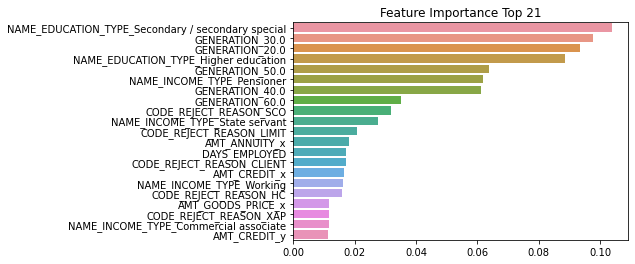

                FN      FP
Capital       -8.0   -10.0
Insurance     -9.0   -13.0
Prediction  6092.0  3135.0
    Capital  Insurance  Prediction
FN     -8.0       -9.0      6092.0
FP    -10.0      -13.0      3135.0
    Capital  Insurance  Prediction  CapitalExpectedLoss  InsuranceExpectedLoss
FN     -8.0       -9.0      6092.0             -48736.0               -54828.0
FP    -10.0      -13.0      3135.0             -31350.0               -40755.0
-80086.0
-95583.0
                   0              1
count  115114.000000  115114.000000
mean        0.497881       0.502119
std         0.455323       0.455323
min         0.000000       0.000000
25%         0.000000       0.042813
50%         0.659259       0.340741
75%         0.957187       1.000000
max         1.000000       1.000000


In [ ]:
DecisionTreeReduction(X = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis = 1),
                      y = y_smote,
                      split_ratio = 0.2,
                      alpha = 0,
                      depth = 18,
                      impurity = "gini")

In [ ]:
# SMOTE로 인해 과잉표본추출된 데이터를 제거하기 위한 과정
# outer merge를 이용하여 제거하려고 했으나 세션이 다운돼서 진행할 수 없음
'''
df = pd.merge(X, X_smote, how='outer', indicator = True)
df2 = pd.merge(y, y_smote, how='outer', indicator = True)
df.query('_merge == "right_only"').drop(columns=['_merge'])
df2.query('_merge == "right_only"').drop(columns=['_merge'])
'''

##### (6) 다수 클래스에서 표본을 소수 클래스 데이터 수로 추출하여 만든 각 모델을 투표 (일종의 ML 버전 Mini Batch)

In [ ]:
df_NCB = NCB_MICE_FS_OD.drop(["SK_ID_CURR", "SK_ID_PREV"], axis = 1)
df_TARGET_0 = df_NCB[df_NCB["TARGET"] == 0]
df_TARGET_1 = df_NCB[df_NCB["TARGET"] == 1]

In [ ]:
def get_train_batch(df_majority, df_minority, start, end):
    # [다수클래스를 분할한(표본추출한) 12개의 batch를 소수클래스 표본과 df_train으로 병합]
  df_train = pd.concat([df_majority[start : end], df_minority], axis = 0, ignore_index = True)

  X_train = df_train.drop("TARGET", axis = 1)
  y_train = df_train["TARGET"]

  return X_train, y_train

In [ ]:
start: int = 0
end: int = len(df_TARGET_1)

while True :
  if end <= len(df_TARGET_0) :
    get_train_batch(df_TARGET_0, df_TARGET_1, start = start, end = end)

    start += len(df_TARGET_1)
    end += len(df_TARGET_1)
  else :
    # end > len(df_TARGET_0)
    break

##### (7) 비용 기반 데이터 가중치 부여한 의사결정 트리 (cost-sensitive decision tree)

* 결정 임계치(threshold)에 부여 :  class probability
* 분할 기준(split criteria)에 반영 : log loss = $ \alpha \cdot p \log{p} + (1-p) \log{1-p} $
* 가지치기(pruning)에 반영
* https://github.com/david-cortes/costsensitive

#### 4-1) Random Forest

In [ ]:
def RF(max_leaf: float, estimators: float):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis =1),
                                                      y_smote,
                                                      stratify = y_smote,
                                                      random_state = 2022,
                                                      test_size = 0.5)

  RandomForest = RandomForestClassifier(random_state = 2023,
                                        max_depth = 16,
                                        criterion = "gini",
                                        max_features = "sqrt",
                                        max_leaf_nodes = max_leaf,
                                        n_estimators = estimators)
  RandomForest.fit(X_train, y_train)
  y_pred = RandomForest.predict(X_test)
  y_pred = np.array(y_pred)
  y_test = np.array(y_test)

  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1:
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0:
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1:
      FP += 1
    if y_test[i] == 0 and y_pred[i] == 0:
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2, 2)
  print(confusionMatrix)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  print("정확도 :", (TP + TN) / (TP + FN + FP + TN))
  print("정밀도 :", Precision)
  print("재현율 :", Recall)
  print("F-Beta 점수 :", ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall))

  # 특징 중요도
  dt_series = pd.Series(RandomForest.feature_importances_, index = X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"],axis=1).columns)
  dt_top_21 = dt_series.sort_values(ascending=False)[:21]
  plt.title("Feature Importance Top 21")
  sns.barplot(x = dt_top_21, y = dt_top_21.index)
  plt.show()

'''
  # 분류 가중치 테이블
  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]
  DBWeights

  # 분류 가중치 단위 조정 : 자연로그 변환
  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  print(classifyWeights)

  classifyWeights = classifyWeights.transpose()
  print(classifyWeights)

  classifyWeights["CapitalExpectedLoss"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedLoss"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
  print(classifyWeights)

  print(sum(classifyWeights["CapitalExpectedLoss"]))
  print(sum(classifyWeights["InsuranceExpectedLoss"]))

  decisionTreeProb = RandomForest.predict_proba(X_test)
  print(pd.DataFrame(decisionTreeProb).describe())
    # [분류 확률의 분포 출력]
'''

[[47202 10355]
 [ 3230 54327]]
정확도 : 0.8819865524610386
정밀도 : 0.9359533629441624
재현율 : 0.820091387667877
F-Beta 점수 : 0.8906541879729042


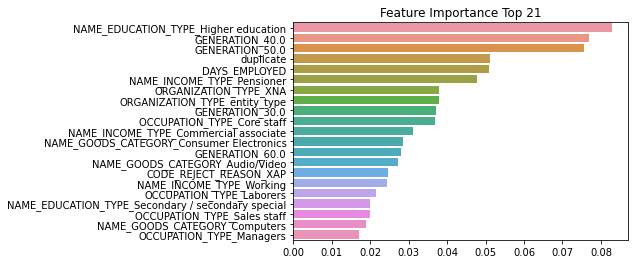

                 FN      FP
Capital        -8.0   -10.0
Insurance      -9.0   -13.0
Prediction  10355.0  3230.0
    Capital  Insurance  Prediction
FN     -8.0       -9.0     10355.0
FP    -10.0      -13.0      3230.0
    Capital  Insurance  Prediction  CapitalExpectedLoss  InsuranceExpectedLoss
FN     -8.0       -9.0     10355.0             -82840.0               -93195.0
FP    -10.0      -13.0      3230.0             -32300.0               -41990.0
-115140.0
-135185.0
                   0              1
count  115114.000000  115114.000000
mean        0.500004       0.499996
std         0.228376       0.228376
min         0.108921       0.138834
25%         0.287838       0.313553
50%         0.554806       0.445194
75%         0.686447       0.712162
max         0.861166       0.891079


In [ ]:
RF2(max_leaf = 16, estimators= 100)

In [ ]:
# RandomForest max_leaf_nodes GridSearch
# n_estimator = 1000으로 하면 6시간 이상 걸림 (미친)

f_beta = make_scorer(fbeta_score, beta=0.75)
RF = RandomForestClassifier(random_state = 2022, n_estimators = 1000)
grid_param = {"max_leaf_nodes": list(range(10, 20, 1))}
gs2 = GridSearchCV(RF, grid_param, cv=5, scoring = f_beta)
gs2.fit(X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"],axis=1), y_smote)

print(f"max_depth 최적 파라미터: {gs2.best_params_}")
print(f"최적 max_depth일 때의 F-beta값: {gs2.best_score_}")

KeyboardInterrupt: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smote.drop(["CODE_GENDER_M", "CODE_GENDER_F"], axis =1),
                                                    y_smote,
                                                    stratify = y_smote,
                                                    random_state = 2022,
                                                    test_size = 0.5)

In [ ]:
# max_depth = 16, split = 0.5

f_beta = make_scorer(fbeta_score, beta=0.75)
RF = RandomForestClassifier(random_state = 2022, max_depth = 16)
grid_param = {"max_leaf_nodes": list(range(10, 20, 1))}
gs2 = GridSearchCV(RF, grid_param, cv=5, scoring = f_beta)
gs2.fit(X_train, y_train)

print(f"max_depth 최적 파라미터: {gs2.best_params_}")
print(f"최적 max_depth일 때의 F-beta값: {gs2.best_score_}")

max_depth 최적 파라미터: {'max_leaf_nodes': 19}
최적 max_depth일 때의 F-beta값: 0.8992027995716245


#### 4-2) Light GBM
* 파라미터 튜닝 : https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

  https://smecsm.tistory.com/133

* 과적합 조정
  * learning_rate(boosting을 반복할 때 업데이트되는 학습률 값)는 작게, n_estimators는 크게 하는 것이 바람직하다.
  * max_depth 줄이기
  * num_leaves 조정
      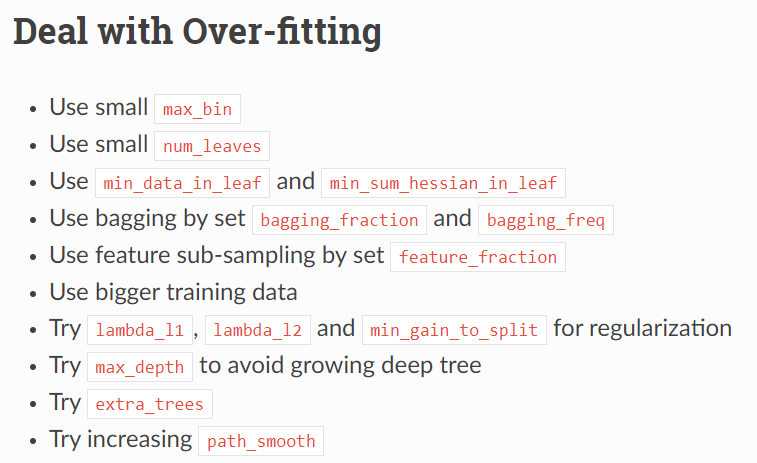

In [ ]:
# LightGBM 성능평가 함수

def lgbm(split_ratio: float, leaves: float, min_leaf: float, app: str, boost: str):
  X_train, X_test, y_train, y_test = train_test_split(X_smote,
                                                      y_smote,
                                                      stratify = y_smote,
                                                      test_size = split_ratio,
                                                      random_state = 2022)

  LGBM = LGBMClassifier(max_depth = 21,
                        num_leaves = leaves,
                          # [전체 트리의 leave 수 ; default 31]
                          # [보통 2^(max_depth) = 2097152 보다 작아야 오버피팅을 막을 수 있다]
                        min_data_in_leaf = min_leaf,
                          # [Leaf가 가지고 있는 최소한의 레코드 수 ; default 20]
                          # [In practice, setting it to hundreds or thousands is enough for a large dataset.]
                        application = app,
                          # ['regression', 'binary', 'muliclass' ; defalut 'regression']
                        boosting = boost
                          # [boosting type : 'gbdt'(Gradient Boosting Decision Tree), 'dart'(Dropouts meet Multiple Additive Regression Trees), 'rf'(Random Forest) ; default gbdt]
                        )
  LGBM.fit(X_train, y_train)
  y_pred = LGBM.predict(X_test)
  y_pred = np.array(y_pred)
  y_test = np.array(y_test)

  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1 :
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0 :
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1 :
      FP += 1
    if y_test[i] == y_pred[i] == 0 :
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2,2)
  print(confusionMatrix)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  print("정확도 :", (TP + TN) / (TP + FN + FP + TN))
  print("정밀도 :", Precision)
  print("재현율 :", Recall)
  print("F-Beta 점수 :", ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall))

  # 특징 중요도
  plot_importance(LGBM, max_num_features = 10)
  plt.show

  # 분류 가중치 테이블
  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]
  DBWeights

  # 분류 가중치 단위 조정 : 자연로그 변환
  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  print(classifyWeights)

  classifyWeights = classifyWeights.transpose()
  print(classifyWeights)

  classifyWeights["CapitalExpectedLoss"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedLoss"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
  print(classifyWeights)

  print(sum(classifyWeights["CapitalExpectedLoss"]))
  print(sum(classifyWeights["InsuranceExpectedLoss"]))

  decisionTreeProb = LGBM.predict_proba(X_test)
  print(pd.DataFrame(decisionTreeProb).describe())
    # [분류 확률의 분포 출력]

[[50582  6975]
 [  189 57368]]
정확도 : 0.9377660406206022
정밀도 : 0.9962774024541569
재현율 : 0.8788157826154942
F-Beta 점수 : 0.9505400462585382
                FN     FP
Capital       -8.0  -10.0
Insurance     -9.0  -13.0
Prediction  6975.0  189.0
    Capital  Insurance  Prediction
FN     -8.0       -9.0      6975.0
FP    -10.0      -13.0       189.0
    Capital  Insurance  Prediction  CapitalExpectedLoss  InsuranceExpectedLoss
FN     -8.0       -9.0      6975.0             -55800.0               -62775.0
FP    -10.0      -13.0       189.0              -1890.0                -2457.0
-57690.0
-65232.0
                   0              1
count  115114.000000  115114.000000
mean        0.499698       0.500302
std         0.416454       0.416454
min         0.000377       0.022102
25%         0.011958       0.106901
50%         0.755975       0.244025
75%         0.893099       0.988042
max         0.977898       0.999623


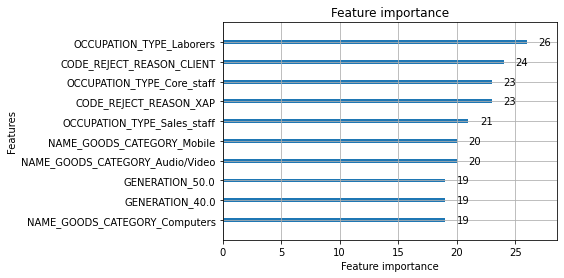

In [ ]:
lgbm(split_ratio = 0.2, leaves = 10, min_leaf = 20, app = 'regression', boost = 'gbdt')

In [ ]:
for g in range(10, 31, 5):
  print(f"num_leaves: {g}")
  print(lgbm(split_ratio = 0.2, leaves = g, min_leaf = 20, app='regression', boost = 'gbdt'))

num_leaves: 10
[[50582  6975]
 [  189 57368]]
정확도 : 0.9377660406206022
정밀도 : 0.9962774024541569
재현율 : 0.8788157826154942
F-Beta 점수 : 0.9505400462585382
                FN     FP
Capital       -8.0  -10.0
Insurance     -9.0  -13.0
Prediction  6975.0  189.0
    Capital  Insurance  Prediction
FN     -8.0       -9.0      6975.0
FP    -10.0      -13.0       189.0
    Capital  Insurance  Prediction  CapitalExpectedLoss  InsuranceExpectedLoss
FN     -8.0       -9.0      6975.0             -55800.0               -62775.0
FP    -10.0      -13.0       189.0              -1890.0                -2457.0
-57690.0
-65232.0
                   0              1
count  115114.000000  115114.000000
mean        0.499698       0.500302
std         0.416454       0.416454
min         0.000377       0.022102
25%         0.011958       0.106901
50%         0.755975       0.244025
75%         0.893099       0.988042
max         0.977898       0.999623
None
num_leaves: 15
[[50976  6581]
 [   87 57470]]
정확도 : 0.9

In [ ]:
g = 0
for g in range(10, 15, 1):
  print(f"num_leaves: {g}")
  print(lgbm(split_ratio = 0.2, leaves = g, min_leaf=20, app='regression', boost = 'gbdt'))

num_leaves: 10
[[50582  6975]
 [  189 57368]]
정확도 : 0.9377660406206022
정밀도 : 0.9962774024541569
재현율 : 0.8788157826154942
F-Beta 점수 : 0.9505400462585382
                FN     FP
Capital       -8.0  -10.0
Insurance     -9.0  -13.0
Prediction  6975.0  189.0
    Capital  Insurance  Prediction
FN     -8.0       -9.0      6975.0
FP    -10.0      -13.0       189.0
    Capital  Insurance  Prediction  CapitalExpectedLoss  InsuranceExpectedLoss
FN     -8.0       -9.0      6975.0             -55800.0               -62775.0
FP    -10.0      -13.0       189.0              -1890.0                -2457.0
-57690.0
-65232.0
                   0              1
count  115114.000000  115114.000000
mean        0.499698       0.500302
std         0.416454       0.416454
min         0.000377       0.022102
25%         0.011958       0.106901
50%         0.755975       0.244025
75%         0.893099       0.988042
max         0.977898       0.999623
None
num_leaves: 11
[[50726  6831]
 [  136 57421]]
정확도 : 0.9

In [ ]:
# 과적합 확인
# train model : train pred

def lgbm2(split_ratio: float, leaves: float, app: str, boost: str):
  X_train, X_test, y_train, y_test = train_test_split(X_smote,
                                                      y_smote,
                                                      stratify = y_smote,
                                                      test_size = split_ratio,
                                                      random_state = 2022)

  LGBM = LGBMClassifier(max_depth = 21,
                        num_leaves = leaves,
                          # [전체 트리의 leave 수 ; default 31]
                        application = app,
                          # ['regression', 'binary', 'muliclass' ; defalut regression]
                        boosting = boost,
                          # [boosting type : 'gbdt'(Gradient Boosting Decision Tree), 'dart'(Dropouts meet Multiple Additive Regression Trees), 'rf'(Random Forest) ; default gbdt]
                        n_estimator = 1000)
  LGBM.fit(X_train, y_train)
  y_pred = LGBM.predict(X_train)
  y_pred = np.array(y_pred)
  y_test = np.array(y_train)

  TP = 0
  FN = 0
  FP = 0
  TN = 0

  for i in range(len(y_pred)):
    if y_test[i] == y_pred[i] == 1 :
      TP += 1
    if y_test[i] == 1 and y_pred[i] == 0 :
      FN += 1
    if y_test[i] == 0 and y_pred[i] == 1 :
      FP += 1
    if y_test[i] == y_pred[i] == 0 :
      TN += 1

  confusionMatrix = np.array([[TP, FN], [FP, TN]]).reshape(2,2)
  print(confusionMatrix)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  print("정확도 :", (TP + TN) / (TP + FN + FP + TN))
  print("정밀도 :", Precision)
  print("재현율 :", Recall)
  print("F-Beta 점수 :", ((1+(0.75**2))*Precision*Recall) / ((0.75**2)*Precision + Recall))

  # 분류 가중치 테이블
  DBCapital = [2735, 23872]
  DBInsurance = [6981, 488399]
  DBCapital = pd.Series(DBCapital)
  DBInsurance = pd.Series(DBInsurance)
  DBWeights = pd.DataFrame({
      "Capital" : DBCapital,
      "Insurance" : DBInsurance
  }).T
  DBWeights.columns = ["FN", "FP"]
  DBWeights

  # 분류 가중치 단위 조정 : 자연로그 변환
  DBWeights_loge = np.log(DBWeights)
  classifyWeights = round(DBWeights_loge, 0)
  classifyWeights = -(classifyWeights)
    # [FN, FP 음수로 치환]
  classifyWeights.at[2,:] = confusionMatrix[[0,1], [1,0]]
    # [confusionMatrix[[0,1], [1,0]] = Prediction(FN, FP의 개수)
  classifyWeights.index = ["Capital", "Insurance", "Prediction"]
  print(classifyWeights)

  classifyWeights = classifyWeights.transpose()
  print(classifyWeights)

  classifyWeights["CapitalExpectedLoss"] = classifyWeights["Capital"] * classifyWeights["Prediction"]
  classifyWeights["InsuranceExpectedLoss"] = classifyWeights["Insurance"] * classifyWeights["Prediction"]
  print(classifyWeights)

  print(sum(classifyWeights["CapitalExpectedLoss"]))
  print(sum(classifyWeights["InsuranceExpectedLoss"]))

  decisionTreeProb = LGBM.predict_proba(X_train)
  print(pd.DataFrame(decisionTreeProb).describe())
    # [분류 확률의 분포 출력]

In [ ]:
lgbm2(split_ratio = 0.2, leaves = 10, app = 'regression', boost = 'gbdt')

[[202264  27962]
 [   744 229482]]
정확도 : 0.9376569110352436
정밀도 : 0.9963351197982345
재현율 : 0.8785454292738439
F-Beta 점수 : 0.9504597792322866
                 FN     FP
Capital        -8.0  -10.0
Insurance      -9.0  -13.0
Prediction  27962.0  744.0
    Capital  Insurance  Prediction
FN     -8.0       -9.0     27962.0
FP    -10.0      -13.0       744.0
    Capital  Insurance  Prediction  CapitalExpectedLoss  InsuranceExpectedLoss
FN     -8.0       -9.0     27962.0            -223696.0              -251658.0
FP    -10.0      -13.0       744.0              -7440.0                -9672.0
-231136.0
-261330.0
                   0              1
count  460452.000000  460452.000000
mean        0.499961       0.500039
std         0.416338       0.416338
min         0.000377       0.022334
25%         0.011951       0.106710
50%         0.755526       0.244474
75%         0.893290       0.988049
max         0.977666       0.999623


#### 3) 나이브 베이지안 분류기 : 가우시안, 베르누이, 범주형

In [ ]:
def BinaryNaiveBayes(X: pd.DataFrame, y: pd.Series, split_ratio: float, smoothing: int, weights: float):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      test_size = split_ratio,
                                                      random_state = 2023)
  binaryNB = BernoulliNB(
      binarize = 0,
      alpha = smoothing,
      fit_prior = True,
      class_prior = None)
        # [binarize] 특성변수 표본을 이진분류하는 임계값으로 X 독립변수는 더미인코딩하여 0(defalut) 설정
        # [alpha] 평활화(스무딩) 여부
        # [fit_prior] 사전확률을 균일분포(0,1)을 따르도록 할 것인지 설정
        # [class_prior] 종속변수의 각 클래스별 사전확률 구체화하지 않고 데이터 분포를 따르도록 설정

  target_wt = [weights if target == 1 else 1 for target in y_train]
      # [sample_weight] 클래스 불균형을 4:1로 완화하기 위해 소수클래스에 가중치 3배 부여
      # [Error] is_scalar(key) and isna(key) and not self.hasnans: KeyError: 0
      # [The sample_weight and class_weight are two different things.]
      # [sample_weight] array-like of shape (n_samples,), default = None

  binaryNB.fit(X_train, y_train, sample_weight = target_wt)
  y_pred_test = binaryNB.predict(X_test)
  y_pred_train = binaryNB.predict(X_train)

  print(dt_eval(y_test, y_pred_test))
  print(dt_eval(y_train, y_pred_train))

In [ ]:
BinaryNaiveBayes(X = X_binsDiscretize, y = y, split_ratio = 0.2, smoothing = 1, weights = 3)

혼동 행렬
[[ 1312  3835]
 [ 7911 49646]]
정확도: 0.8126754274049502
정밀도: 0.1422530629946872
재현율: 0.2549057703516612
F1: 0.18260264439805152
F-0.75: 0.16916721250599565
None
혼동 행렬
[[  5219  15370]
 [ 31616 198610]]
정확도: 0.8126667065366904
정밀도: 0.14168589656576625
재현율: 0.25348487056195057
F1: 0.18177068821398717
F-0.75: 0.16842851260099578
None


In [ ]:
BinaryNaiveBayes(X = X_smote, y = y_smote, split_ratio = 0.2, smoothing = 1, weights = 3)

혼동 행렬
[[50959  6598]
 [ 6935 50622]]
정확도: 0.8824382785760203
정밀도: 0.8802121117905137
재현율: 0.8853658112827284
F1: 0.882781439745
F-0.75: 0.8820605171856317
None
혼동 행렬
[[203750  26476]
 [ 27781 202445]]
정확도: 0.8821657849243787
정밀도: 0.8800117478868921
재현율: 0.8849999565644193
F1: 0.8824988034832173
F-0.75: 0.881801012026251
None


In [ ]:
def CategoricalNaiveBayes(X: pd.DataFrame, split_ratio: float, smoothing: int, weights: float):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      test_size = split_ratio,
                                                      random_state = 2023)
  binaryNB = CategoricalNB(
      binarize = 0,
      alpha = smoothing,
      fit_prior = True,
      class_prior = None)
        # [binarize] 특성변수 표본을 이진분류하는 임계값으로 X 독립변수는 더미 인코딩하여 0(defalut) 설정
        # [alpha] 평활화(스무딩) 여부
        # [fit_prior] 사전확률을 균일분포(0,1)을 따르도록 할 것인지 설정
        # [class_prior] 종속변수의 각 클래스별 사전확률 구체화하지 않고 데이터 분포를 따르도록 설정

  target_wt = [weights if target == 1 else 1 for target in y_train]

  binaryNB.fit(X_train, y_train, sample_weight = target_wt)
  y_pred_test = binaryNB.predict(X_test)
  y_pred_train = binaryNB.predict(X_train)

  print(dt_eval(y_test, y_pred_test))
  print(dt_eval(y_train, y_pred_train))

In [ ]:
CategoricalNaiveBayes(X = X_reduction, split_ratio = 0.2, smoothing = 1, weights = 3)

혼동 행렬
[[  924  4223]
 [ 4393 53164]]
정확도: 0.8625924980862465
정밀도: 0.17378220801203687
재현율: 0.17952205168059063
F1: 0.17660550458715596
F-0.75: 0.17580577647551274
None
혼동 행렬
[[  3616  16973]
 [ 17564 212662]]
정확도: 0.862300899069035
정밀도: 0.17072710103871577
재현율: 0.17562776239739666
F1: 0.1731427613780555
F-0.75: 0.17245951303080428
None


#### 4) 이항 로지스틱 회귀분석

In [ ]:
def BinaryLogisticRegression(X: pd.DataFrame, y: pd.Series, split_ratio: float):
  np.random.seed(2023)
  X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      stratify = y,
                                                      test_size = split_ratio,
                                                      random_state = 2023)

  glm = LogisticRegression()
  glm.fit(X_train, y_train)
  y_pred_test = glm.predict(X_test)
  y_pred_train = glm.predict(X_train)

  print(dt_eval(y_test, y_pred_test))
  print(dt_eval(y_train, y_pred_train))

  sns.boxplot(glm.predict_proba(X_test))

BinaryLogisticRegression(X = X_smote.drop(["CODE_GENDER_F", "CODE_GENDER_M"], axis = 1), y = y_smote, split_ratio = 0.2)

#### 5) 서포트 벡터 머신